In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, LSTMCell, RNN
sys.path.append('../classes')
from my_window import DataWindow,MetaBaselineDataWindow #type: ignore
from baseline import Baseline,MultiStepLastBaseline,MetaBaseline,AverageBaseline,CopyBaseline,LastValueBaseline,RepeatBaseline #type: ignore
from helper_tools import print_perf,compile_and_fit  #type: ignore
warnings.filterwarnings('ignore')

We will continue to build on lesson 7 and this time use architectures that are more specialized for time series : LSTM and CNN
First thing is to load the results of last lesson to compare it with the results we will produce here.

In [26]:
import json

# loaded now contains every result of the last lesson in a json
with open('../data/perf_dict.json', 'r') as f: 
    loaded_combined_dict = json.load(f)
    
# we also set parameters for visualization 
plt.rcParams['figure.figsize'] = (15, 7.5)
plt.rcParams['axes.grid'] = False
tf.random.set_seed(42)
np.random.seed(42)

train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)


We will nee again all the windows to plot and work with the dataset 

In [8]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

Long Short-Term Memory (LSTM) networks are a type of artificial neural network designed to process sequences of data, like sentences in text or steps in a time series. Unlike standard feedforward neural networks, LSTMs have a special mechanism to remember and connect information across long sequences, avoiding the problem of "forgetting" earlier data in the sequence. This is achieved through a system of gates (input, forget, and output gates) that control the flow of information, allowing the network to retain or discard data based on its relevance. This makes LSTMs particularly effective for tasks like language translation, speech recognition, and sequence prediction where context and order of data are crucial.

Implementing them is particularily easy.

Epoch 1/50
384/384 [==============================] - 8s 10ms/step - loss: 0.0415 - mean_absolute_error: 0.1479 - val_loss: 0.0110 - val_mean_absolute_error: 0.0818
Epoch 2/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0094 - mean_absolute_error: 0.0690 - val_loss: 0.0089 - val_mean_absolute_error: 0.0674
Epoch 3/50
384/384 [==============================] - 3s 9ms/step - loss: 0.0087 - mean_absolute_error: 0.0655 - val_loss: 0.0085 - val_mean_absolute_error: 0.0670
Epoch 4/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0084 - mean_absolute_error: 0.0645 - val_loss: 0.0082 - val_mean_absolute_error: 0.0654
Epoch 5/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0082 - mean_absolute_error: 0.0640 - val_loss: 0.0081 - val_mean_absolute_error: 0.0663
Epoch 6/50
384/384 [==============================] - 4s 10ms/step - loss: 0.0080 - mean_absolute_error: 0.0636 - val_loss: 0.0076 - val_mean_absolute_error: 0.0616
Epoch 7/50
384

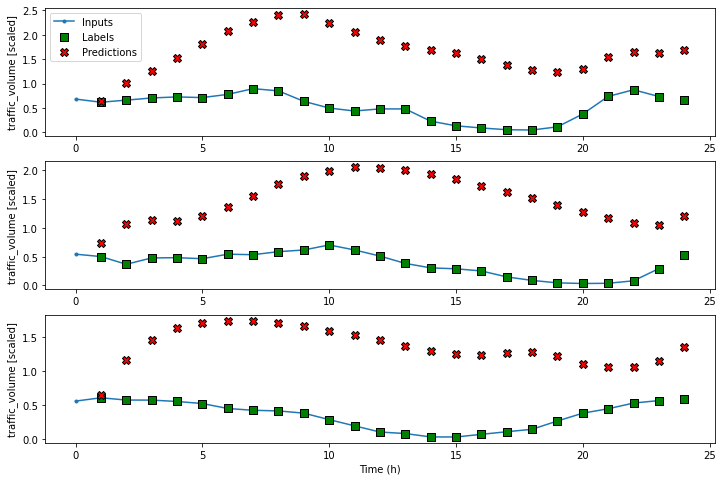

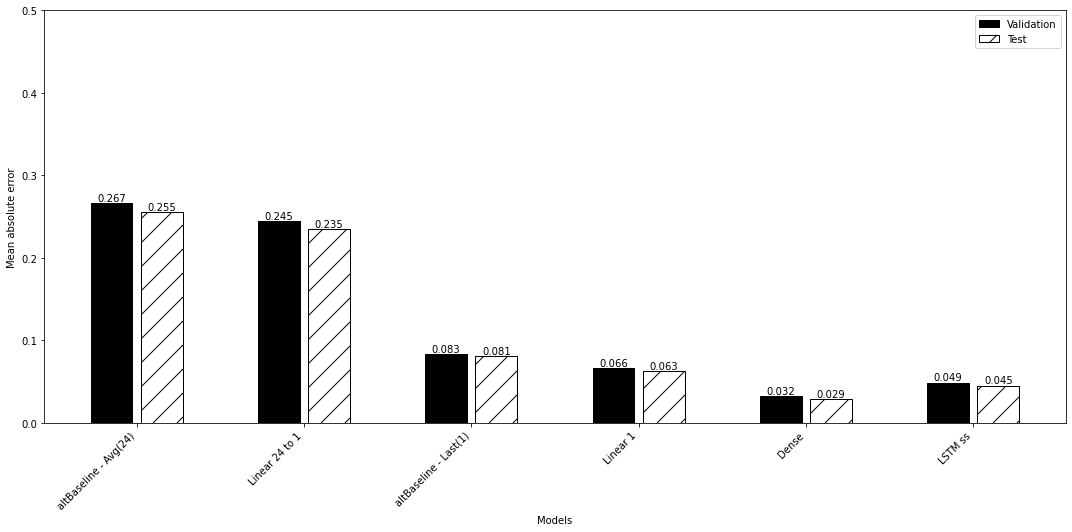

In [9]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, single_step_window)
loaded_combined_dict["single"]["val_perf"]['LSTM ss'] = lstm_model.evaluate(single_step_window.val)
loaded_combined_dict["single"]["perf"]['LSTM ss'] = lstm_model.evaluate(single_step_window.test, verbose=0)
wide_window.plot(lstm_model)
print_perf(loaded_combined_dict["single"]["perf"],loaded_combined_dict["single"]["val_perf"])

Epoch 1/50
384/384 [==============================] - 14s 24ms/step - loss: 0.0362 - mean_absolute_error: 0.1348 - val_loss: 0.0134 - val_mean_absolute_error: 0.0852
Epoch 2/50
384/384 [==============================] - 10s 25ms/step - loss: 0.0089 - mean_absolute_error: 0.0677 - val_loss: 0.0058 - val_mean_absolute_error: 0.0552
Epoch 3/50
384/384 [==============================] - 10s 27ms/step - loss: 0.0052 - mean_absolute_error: 0.0518 - val_loss: 0.0044 - val_mean_absolute_error: 0.0483
Epoch 4/50
384/384 [==============================] - 13s 34ms/step - loss: 0.0044 - mean_absolute_error: 0.0473 - val_loss: 0.0037 - val_mean_absolute_error: 0.0432
Epoch 5/50
384/384 [==============================] - 10s 27ms/step - loss: 0.0039 - mean_absolute_error: 0.0440 - val_loss: 0.0036 - val_mean_absolute_error: 0.0432
Epoch 6/50
384/384 [==============================] - 10s 27ms/step - loss: 0.0036 - mean_absolute_error: 0.0420 - val_loss: 0.0031 - val_mean_absolute_error: 0.0403
Epoc

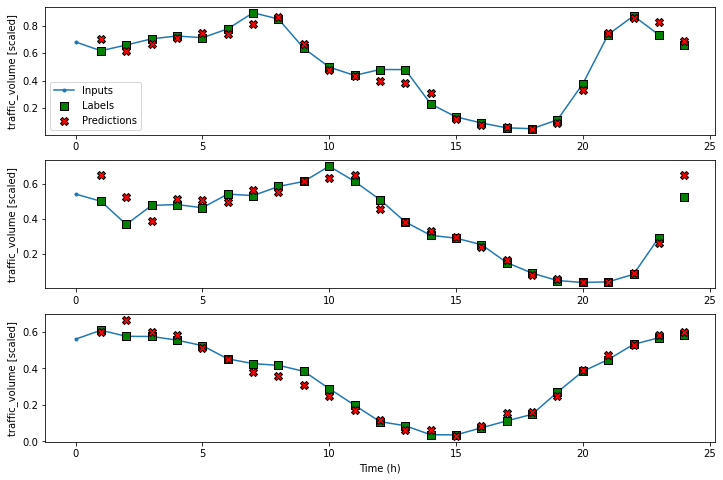

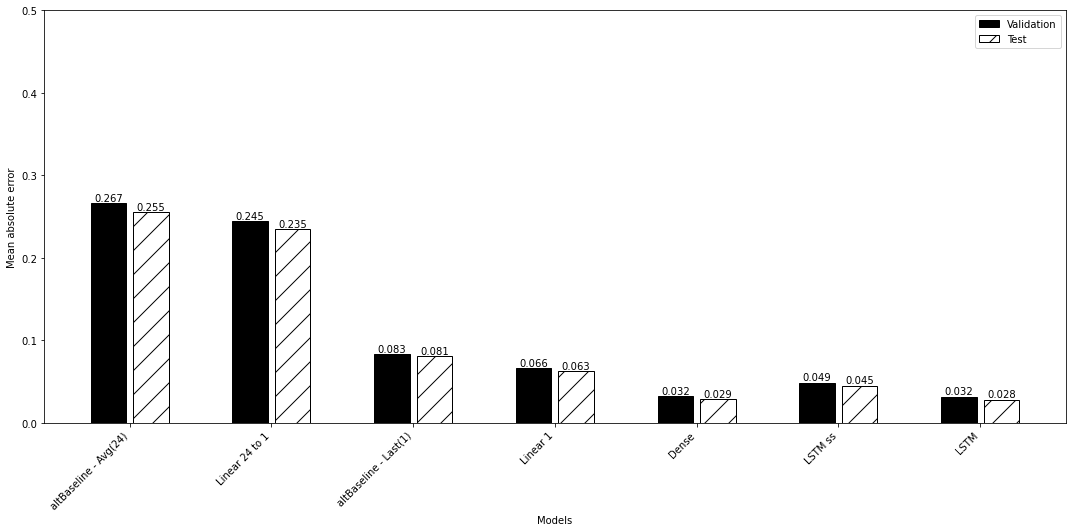

In [10]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)
loaded_combined_dict["single"]["val_perf"]['LSTM'] = lstm_model.evaluate(wide_window.val)
loaded_combined_dict["single"]["perf"]['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)
print_perf(loaded_combined_dict["single"]["perf"],loaded_combined_dict["single"]["val_perf"])

It can also be used with different outputs such as multistep.

Epoch 1/50
383/383 [==============================] - 9s 15ms/step - loss: 0.0482 - mean_absolute_error: 0.1580 - val_loss: 0.0201 - val_mean_absolute_error: 0.0995
Epoch 2/50
383/383 [==============================] - 5s 14ms/step - loss: 0.0166 - mean_absolute_error: 0.0887 - val_loss: 0.0176 - val_mean_absolute_error: 0.0897
Epoch 3/50
383/383 [==============================] - 6s 15ms/step - loss: 0.0153 - mean_absolute_error: 0.0837 - val_loss: 0.0168 - val_mean_absolute_error: 0.0859
Epoch 4/50
383/383 [==============================] - 7s 17ms/step - loss: 0.0147 - mean_absolute_error: 0.0812 - val_loss: 0.0165 - val_mean_absolute_error: 0.0844
Epoch 5/50
383/383 [==============================] - 7s 18ms/step - loss: 0.0144 - mean_absolute_error: 0.0799 - val_loss: 0.0162 - val_mean_absolute_error: 0.0830
Epoch 6/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0142 - mean_absolute_error: 0.0795 - val_loss: 0.0165 - val_mean_absolute_error: 0.0831
Epoch 7/50

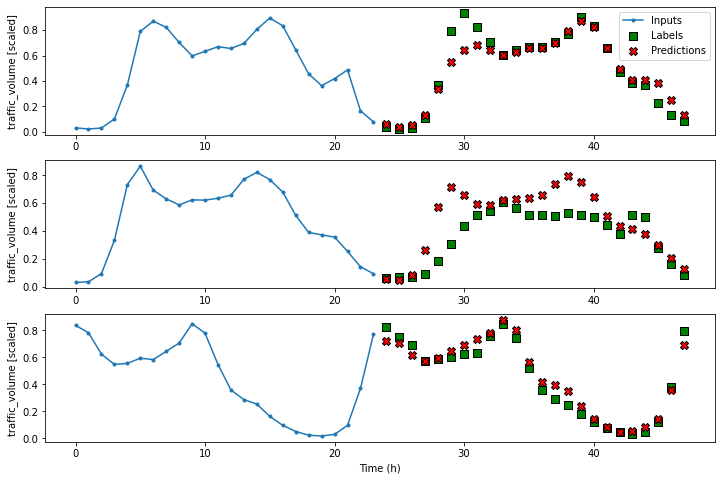

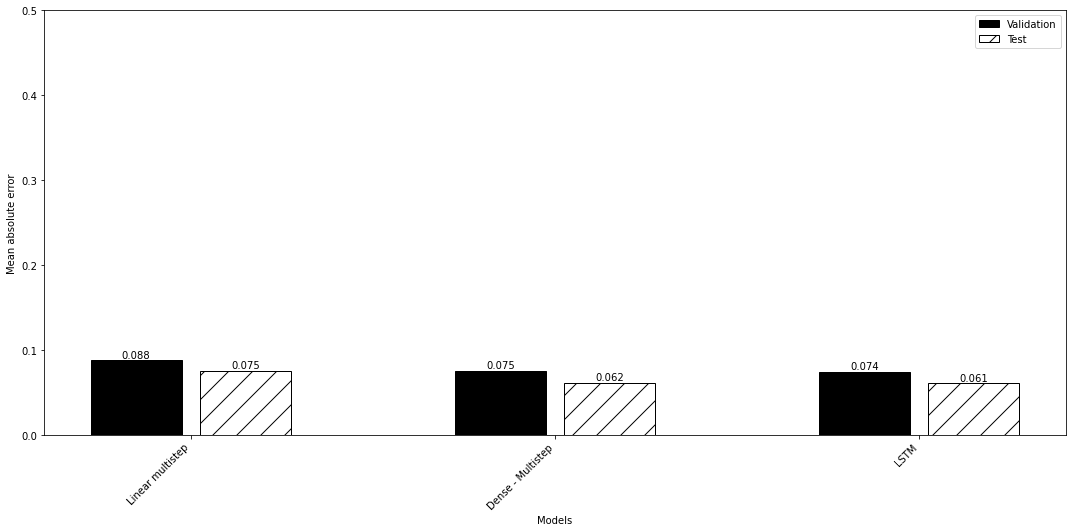

In [11]:

ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

loaded_combined_dict["multistep"]["val_perf"]['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
loaded_combined_dict["multistep"]["perf"]['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

multi_window.plot(ms_lstm_model)
print_perf(loaded_combined_dict["multistep"]["perf"],loaded_combined_dict["multistep"]["val_perf"])

Again it can be used with another output : multi output, the last layer has to provide the right number of units to fit the number of outputs

Epoch 1/50
384/384 [==============================] - 15s 25ms/step - loss: 0.0202 - mean_absolute_error: 0.0942 - val_loss: 0.0083 - val_mean_absolute_error: 0.0597
Epoch 2/50
384/384 [==============================] - 9s 23ms/step - loss: 0.0052 - mean_absolute_error: 0.0465 - val_loss: 0.0034 - val_mean_absolute_error: 0.0376
Epoch 3/50
384/384 [==============================] - 10s 26ms/step - loss: 0.0031 - mean_absolute_error: 0.0352 - val_loss: 0.0025 - val_mean_absolute_error: 0.0324
Epoch 4/50
384/384 [==============================] - 12s 31ms/step - loss: 0.0027 - mean_absolute_error: 0.0322 - val_loss: 0.0021 - val_mean_absolute_error: 0.0301
Epoch 5/50
384/384 [==============================] - 13s 34ms/step - loss: 0.0024 - mean_absolute_error: 0.0300 - val_loss: 0.0019 - val_mean_absolute_error: 0.0278
Epoch 6/50
384/384 [==============================] - 11s 29ms/step - loss: 0.0021 - mean_absolute_error: 0.0282 - val_loss: 0.0017 - val_mean_absolute_error: 0.0268
Epoch

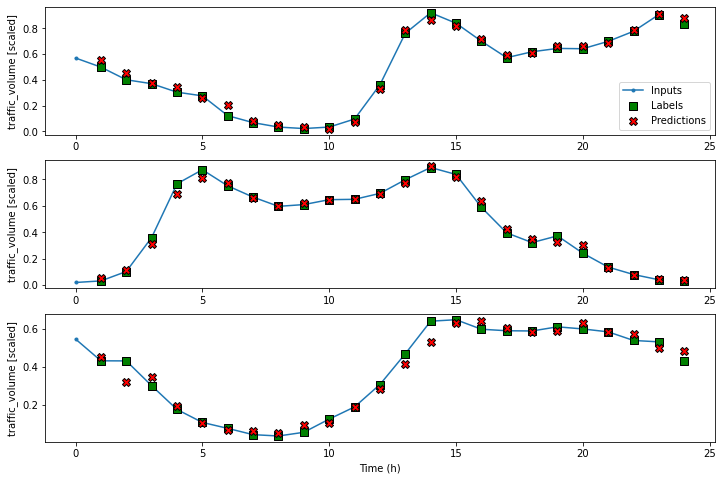

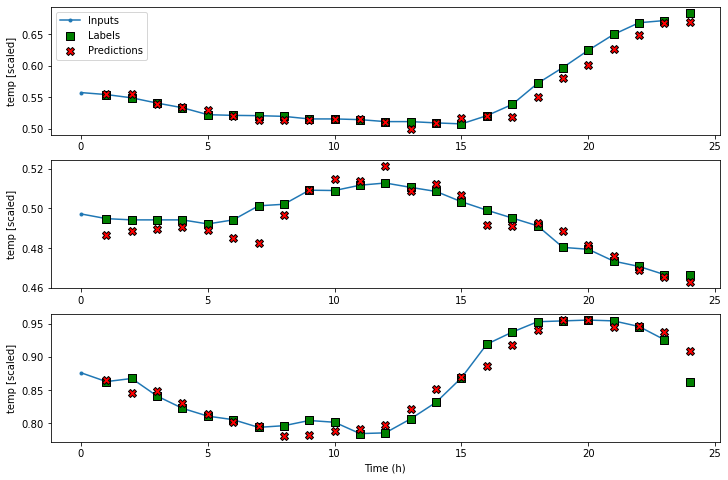

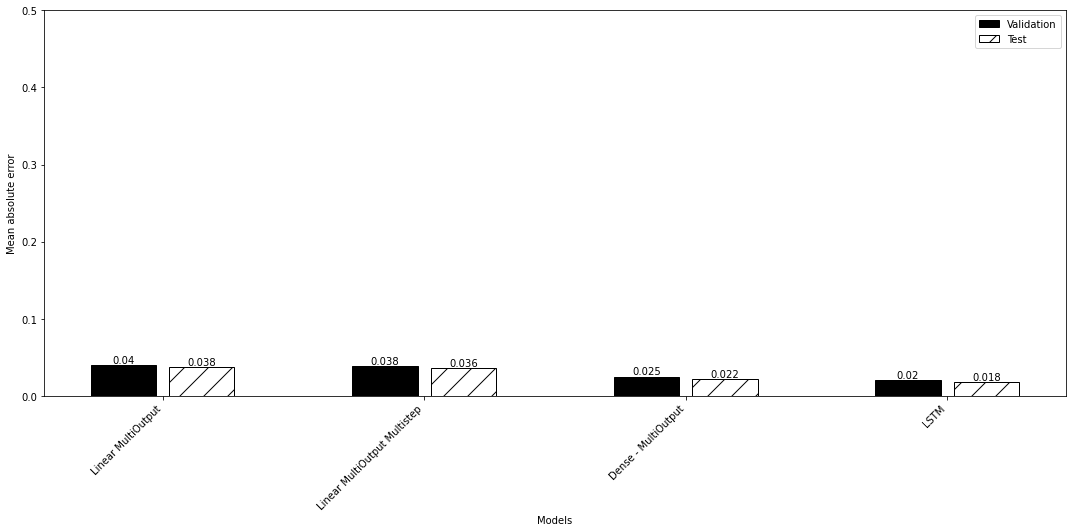

In [12]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)


loaded_combined_dict["multi-output"]["val_perf"]['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
loaded_combined_dict["multi-output"]["perf"]['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)
mo_wide_window.plot(mo_lstm_model)
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

print_perf(loaded_combined_dict["multi-output"]["perf"],loaded_combined_dict["multi-output"]["val_perf"])

Convolutional Neural Networks (CNNs) are a type of deep learning model primarily used in image processing and computer vision. However, their application has expanded to time series analysis, where they can effectively handle sequential data. In time series, CNNs are used for tasks like anomaly detection, forecasting, and pattern recognition. They excel in extracting features from time-dependent data, recognizing patterns, and capturing temporal dependencies, which are crucial in understanding and predicting time series behaviors.

A kernel in the context of time series analysis, particularly when using Convolutional Neural Networks (CNNs), is a small matrix used to perform convolution operations. The kernel slides over the time series data, processing one segment at a time. This process helps in extracting features by applying a filter across the time series. For example, in a 1D time series, a kernel might move across the data points, multiplying its values with the corresponding data points and summing them up, thus transforming the data into a feature map.

This feature extraction is useful for identifying patterns, trends, or anomalies in time series data. The choice of kernel size and the type of operation (like averaging, differentiating, etc.) can significantly influence the kind of features extracted from the time series.

In [13]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

Epoch 1/50
384/384 [==============================] - 3s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0804 - val_loss: 0.0063 - val_mean_absolute_error: 0.0588
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0054 - mean_absolute_error: 0.0547 - val_loss: 0.0041 - val_mean_absolute_error: 0.0487
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0475 - val_loss: 0.0036 - val_mean_absolute_error: 0.0454
Epoch 4/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0436 - val_loss: 0.0029 - val_mean_absolute_error: 0.0409
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0410 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0395 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392
Epoch 7/50
384/3

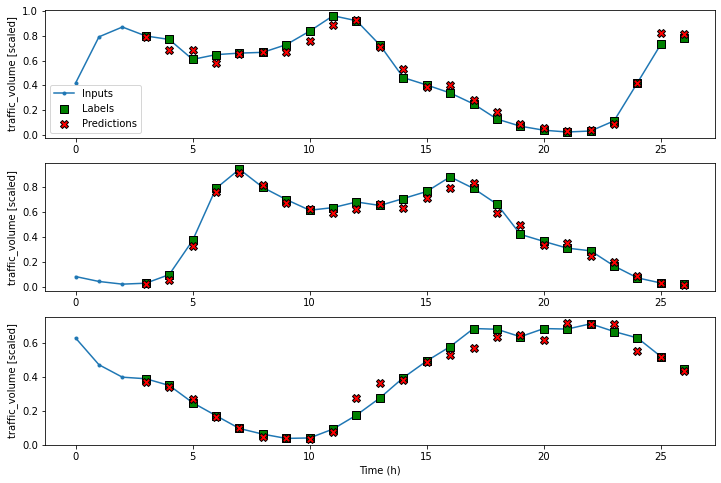

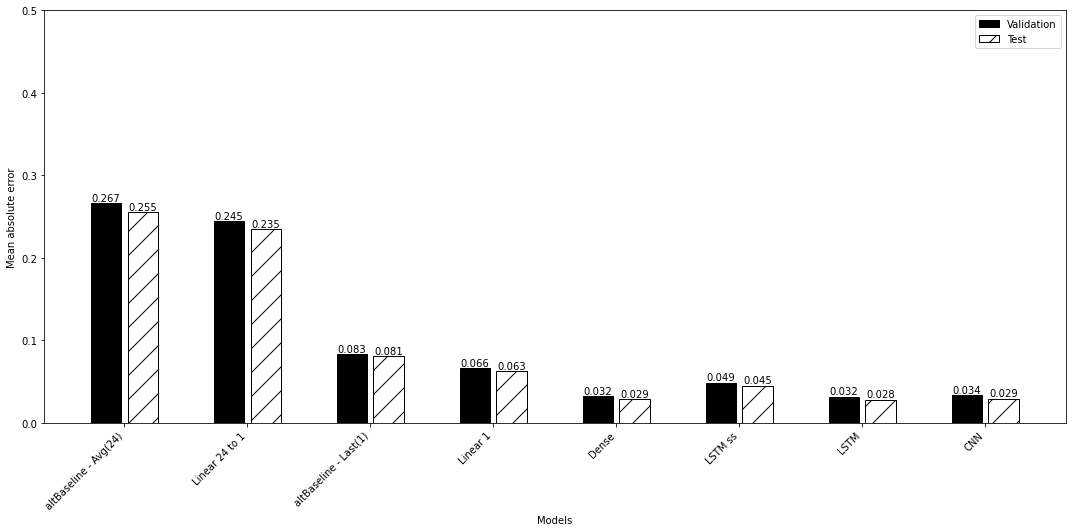

In [14]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)


loaded_combined_dict["single"]["val_perf"]['CNN'] = cnn_model.evaluate(conv_window.val)
loaded_combined_dict["single"]["perf"]['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)
wide_conv_window.plot(cnn_model)
print_perf(loaded_combined_dict["single"]["perf"],loaded_combined_dict["single"]["val_perf"])

The beauty of these architectures is that they can be combined !

Epoch 1/50
384/384 [==============================] - 12s 15ms/step - loss: 0.0359 - mean_absolute_error: 0.1255 - val_loss: 0.0074 - val_mean_absolute_error: 0.0641
Epoch 2/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0062 - mean_absolute_error: 0.0582 - val_loss: 0.0046 - val_mean_absolute_error: 0.0509
Epoch 3/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0046 - mean_absolute_error: 0.0505 - val_loss: 0.0036 - val_mean_absolute_error: 0.0460
Epoch 4/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0039 - mean_absolute_error: 0.0461 - val_loss: 0.0031 - val_mean_absolute_error: 0.0420
Epoch 5/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0036 - mean_absolute_error: 0.0439 - val_loss: 0.0030 - val_mean_absolute_error: 0.0415
Epoch 6/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0028 - val_mean_absolute_error: 0.0394
Epoch 7/5

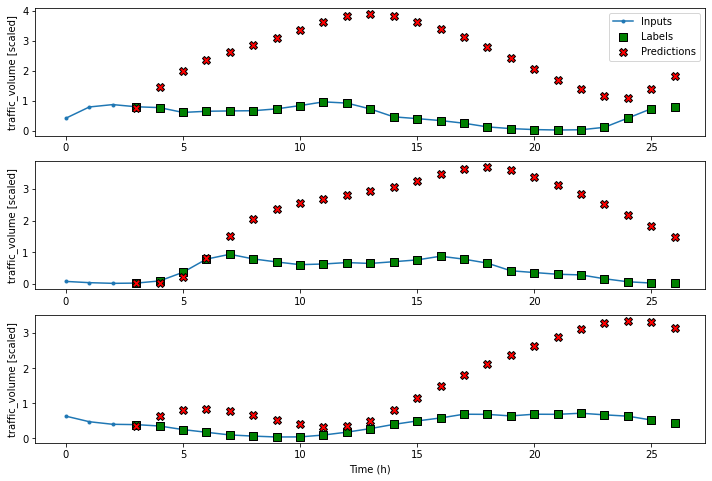

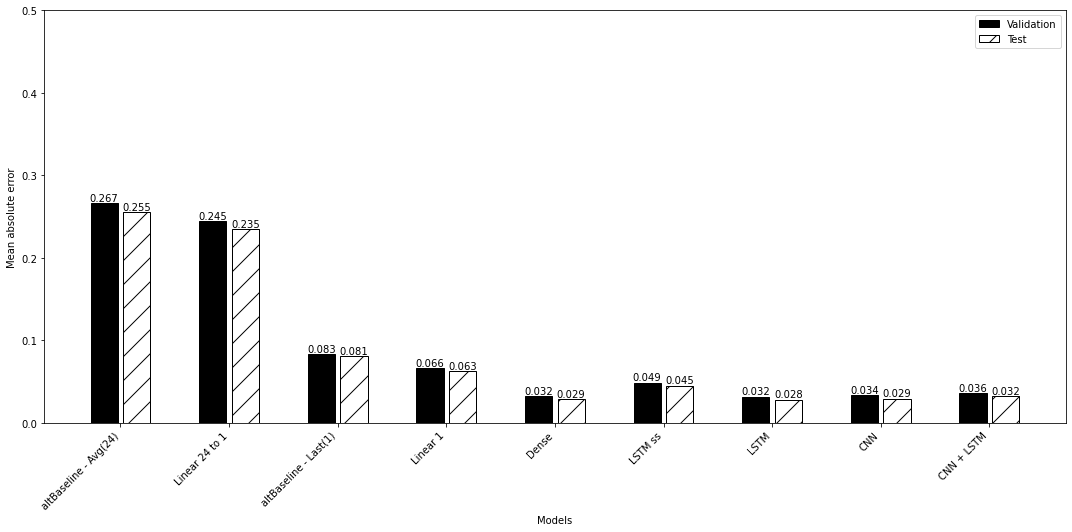

In [15]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

loaded_combined_dict["single"]["val_perf"]['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
loaded_combined_dict["single"]["perf"]['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)
wide_conv_window.plot(cnn_lstm_model)
print_perf(loaded_combined_dict["single"]["perf"],loaded_combined_dict["single"]["val_perf"])

In [16]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

Epoch 1/50
383/383 [==============================] - 5s 8ms/step - loss: 0.0338 - mean_absolute_error: 0.1243 - val_loss: 0.0167 - val_mean_absolute_error: 0.0872
Epoch 2/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0143 - mean_absolute_error: 0.0796 - val_loss: 0.0164 - val_mean_absolute_error: 0.0858
Epoch 3/50
383/383 [==============================] - 3s 9ms/step - loss: 0.0141 - mean_absolute_error: 0.0788 - val_loss: 0.0166 - val_mean_absolute_error: 0.0869
Epoch 4/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0140 - mean_absolute_error: 0.0787 - val_loss: 0.0160 - val_mean_absolute_error: 0.0842
Epoch 5/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0139 - mean_absolute_error: 0.0784 - val_loss: 0.0161 - val_mean_absolute_error: 0.0832
Epoch 6/50
383/383 [==============================] - 3s 9ms/step - loss: 0.0137 - mean_absolute_error: 0.0779 - val_loss: 0.0160 - val_mean_absolute_error: 0.0835
Epoch 7/50
383/

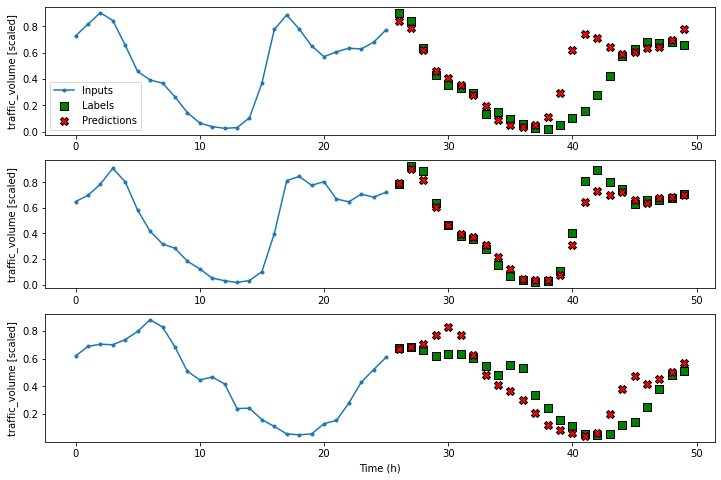

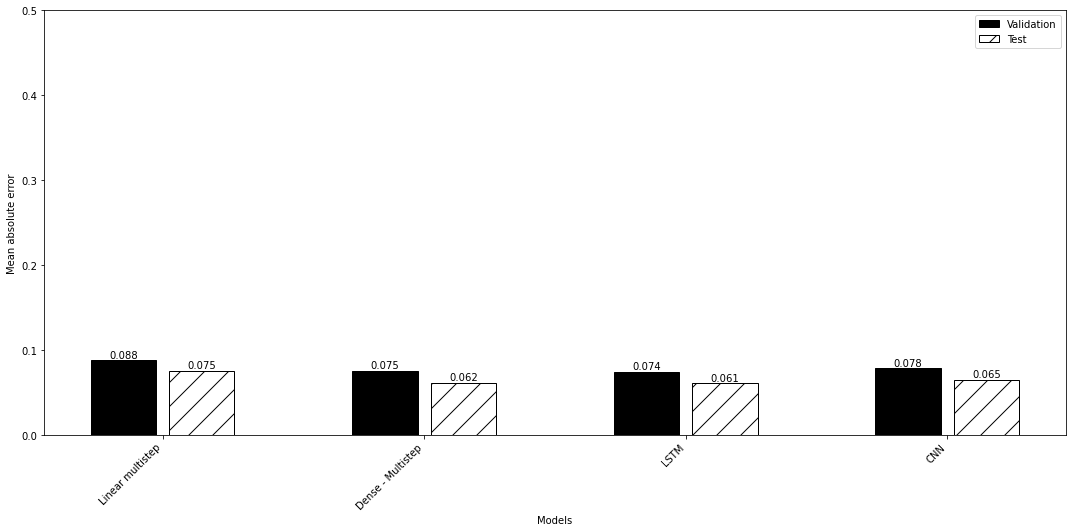

In [17]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

loaded_combined_dict["multistep"]["val_perf"]['CNN'] = ms_cnn_model.evaluate(multi_window.val)
loaded_combined_dict["multistep"]["perf"]['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

multi_window.plot(ms_cnn_model)
print_perf(loaded_combined_dict["multistep"]["perf"],loaded_combined_dict["multistep"]["val_perf"])

Epoch 1/50
383/383 [==============================] - 28s 36ms/step - loss: 0.0388 - mean_absolute_error: 0.1370 - val_loss: 0.0168 - val_mean_absolute_error: 0.0870
Epoch 2/50
383/383 [==============================] - 13s 33ms/step - loss: 0.0143 - mean_absolute_error: 0.0799 - val_loss: 0.0163 - val_mean_absolute_error: 0.0865
Epoch 3/50
383/383 [==============================] - 13s 34ms/step - loss: 0.0138 - mean_absolute_error: 0.0775 - val_loss: 0.0159 - val_mean_absolute_error: 0.0851
Epoch 4/50
383/383 [==============================] - 13s 33ms/step - loss: 0.0134 - mean_absolute_error: 0.0763 - val_loss: 0.0152 - val_mean_absolute_error: 0.0804
Epoch 5/50
383/383 [==============================] - 12s 31ms/step - loss: 0.0130 - mean_absolute_error: 0.0751 - val_loss: 0.0153 - val_mean_absolute_error: 0.0847
Epoch 6/50
383/383 [==============================] - 12s 31ms/step - loss: 0.0126 - mean_absolute_error: 0.0741 - val_loss: 0.0141 - val_mean_absolute_error: 0.0780
Epoc

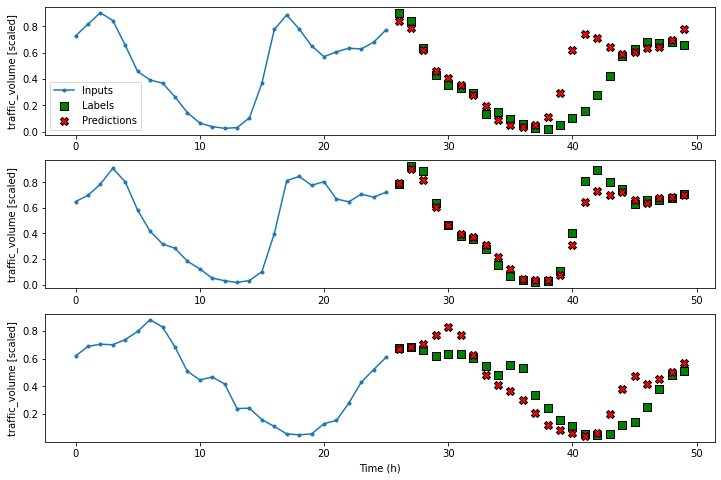

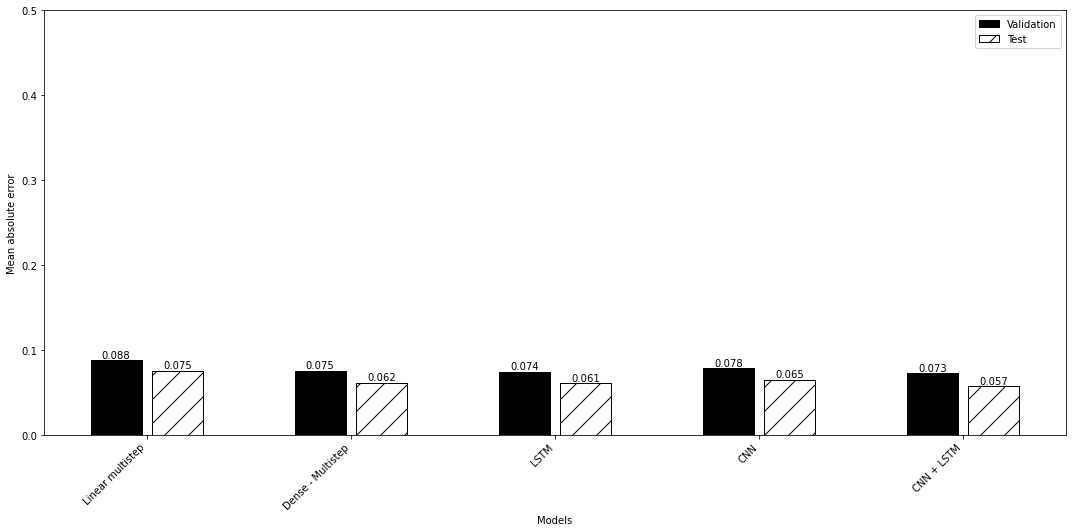

In [18]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

loaded_combined_dict["multistep"]["val_perf"]['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
loaded_combined_dict["multistep"]["perf"]['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(ms_cnn_model)
print_perf(loaded_combined_dict["multistep"]["perf"],loaded_combined_dict["multistep"]["val_perf"])

In [19]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

Epoch 1/50
384/384 [==============================] - 8s 13ms/step - loss: 0.0228 - mean_absolute_error: 0.0835 - val_loss: 0.0027 - val_mean_absolute_error: 0.0359
Epoch 2/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0331 - val_loss: 0.0021 - val_mean_absolute_error: 0.0314
Epoch 3/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0300 - val_loss: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 4/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0275 - val_loss: 0.0015 - val_mean_absolute_error: 0.0256
Epoch 5/50
384/384 [==============================] - 4s 10ms/step - loss: 0.0017 - mean_absolute_error: 0.0255 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240
Epoch 6/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0243 - val_loss: 0.0014 - val_mean_absolute_error: 0.0266
Epoch 7/50
38

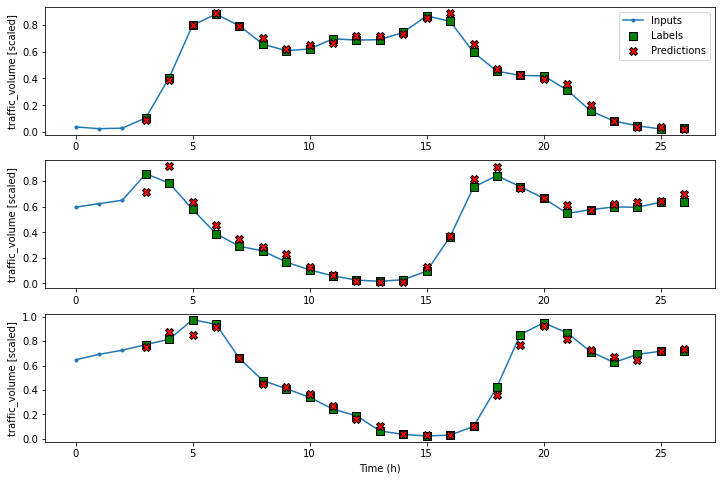

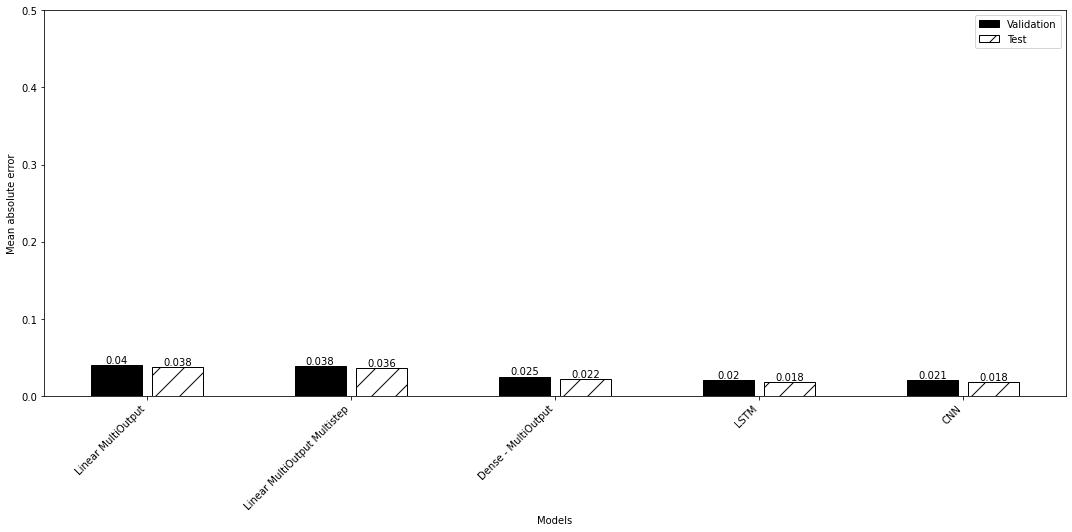

In [20]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)


loaded_combined_dict["multi-output"]["val_perf"]['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
loaded_combined_dict["multi-output"]["perf"]['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

wide_mo_conv_window.plot(mo_cnn_model)
print_perf(loaded_combined_dict["multi-output"]["perf"],loaded_combined_dict["multi-output"]["val_perf"])

Epoch 1/50
384/384 [==============================] - 44s 61ms/step - loss: 0.0252 - mean_absolute_error: 0.0990 - val_loss: 0.0048 - val_mean_absolute_error: 0.0457
Epoch 2/50
384/384 [==============================] - 22s 58ms/step - loss: 0.0034 - mean_absolute_error: 0.0394 - val_loss: 0.0028 - val_mean_absolute_error: 0.0360
Epoch 3/50
384/384 [==============================] - 24s 62ms/step - loss: 0.0025 - mean_absolute_error: 0.0328 - val_loss: 0.0020 - val_mean_absolute_error: 0.0311
Epoch 4/50
384/384 [==============================] - 24s 63ms/step - loss: 0.0021 - mean_absolute_error: 0.0305 - val_loss: 0.0017 - val_mean_absolute_error: 0.0278
Epoch 5/50
384/384 [==============================] - 28s 72ms/step - loss: 0.0019 - mean_absolute_error: 0.0281 - val_loss: 0.0016 - val_mean_absolute_error: 0.0275
Epoch 6/50
384/384 [==============================] - 24s 63ms/step - loss: 0.0017 - mean_absolute_error: 0.0269 - val_loss: 0.0014 - val_mean_absolute_error: 0.0255
Epoc

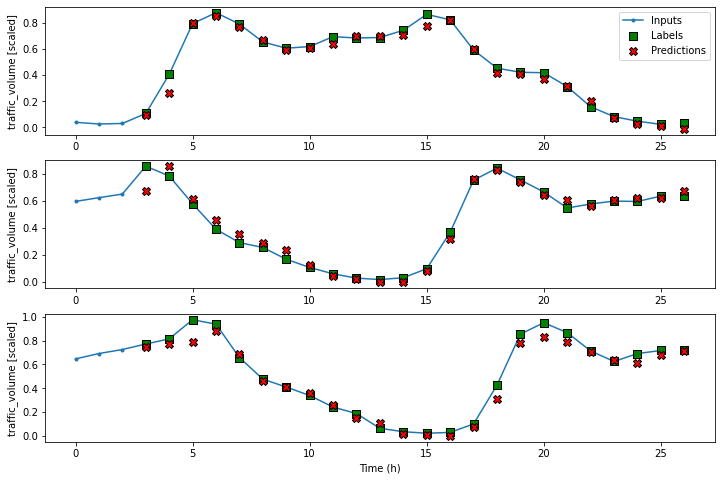

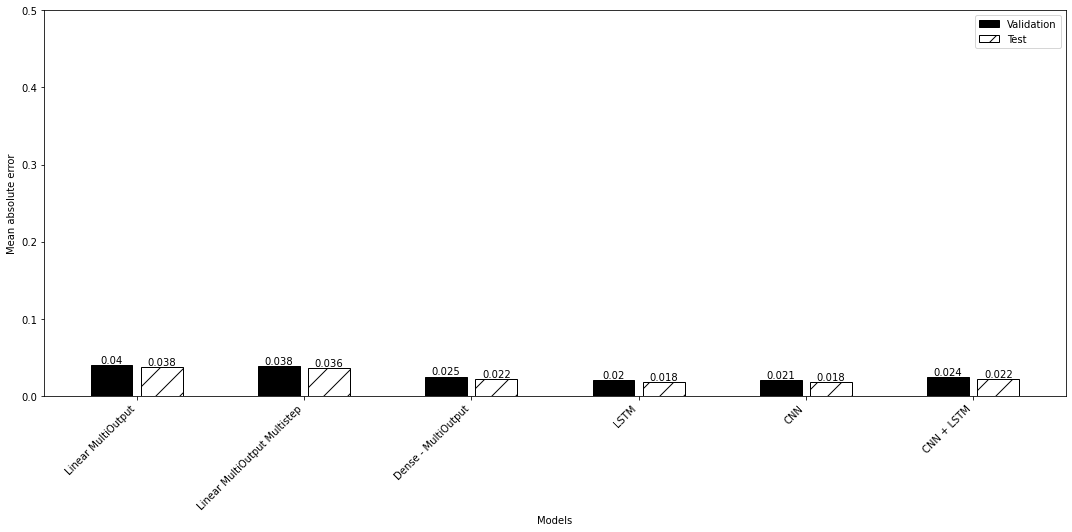

In [21]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

loaded_combined_dict["multi-output"]["val_perf"]['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.val)
loaded_combined_dict["multi-output"]["perf"]['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.test, verbose=0)

wide_mo_conv_window.plot(mo_cnn_lstm_model)
print_perf(loaded_combined_dict["multi-output"]["perf"],loaded_combined_dict["multi-output"]["val_perf"])

The last element we introduce here is auto regressive LSTM : it means LSTM that uses their own prediction to continue predicting. Go back to chapter 5 to read again VARMAX models 

In [28]:
class AutoRegressive(Model):
    # units is the number of neurons in the layer and out steps is the lenght of the prediction we want to operate 
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        # LSTMCell is low level and allows us to acces more specific elements and it has to be wrapped into a RNN
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        # we add a last layer to operate the prediction 
        self.dense = Dense(train_df.shape[1])
        
    # we define a function for the first prediction that is given by the model
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    
    def call(self, inputs, training=None):
        predictions = []
        # let's get the first prediction
        prediction, state = self.warmup(inputs)
        
        #then we stack and operate the prediction on top of predictions 
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        # we need to adapt the shape to fit tensorflow standards
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

Epoch 1/50
383/383 [==============================] - 12s 18ms/step - loss: 0.0469 - mean_absolute_error: 0.1629 - val_loss: 0.0191 - val_mean_absolute_error: 0.0988
Epoch 2/50
383/383 [==============================] - 7s 19ms/step - loss: 0.0161 - mean_absolute_error: 0.0901 - val_loss: 0.0182 - val_mean_absolute_error: 0.0963
Epoch 3/50
383/383 [==============================] - 8s 21ms/step - loss: 0.0153 - mean_absolute_error: 0.0864 - val_loss: 0.0171 - val_mean_absolute_error: 0.0925
Epoch 4/50
383/383 [==============================] - 8s 21ms/step - loss: 0.0147 - mean_absolute_error: 0.0842 - val_loss: 0.0168 - val_mean_absolute_error: 0.0918
Epoch 5/50
383/383 [==============================] - 8s 22ms/step - loss: 0.0144 - mean_absolute_error: 0.0830 - val_loss: 0.0158 - val_mean_absolute_error: 0.0843
Epoch 6/50
383/383 [==============================] - 9s 23ms/step - loss: 0.0140 - mean_absolute_error: 0.0814 - val_loss: 0.0151 - val_mean_absolute_error: 0.0840
Epoch 7/5

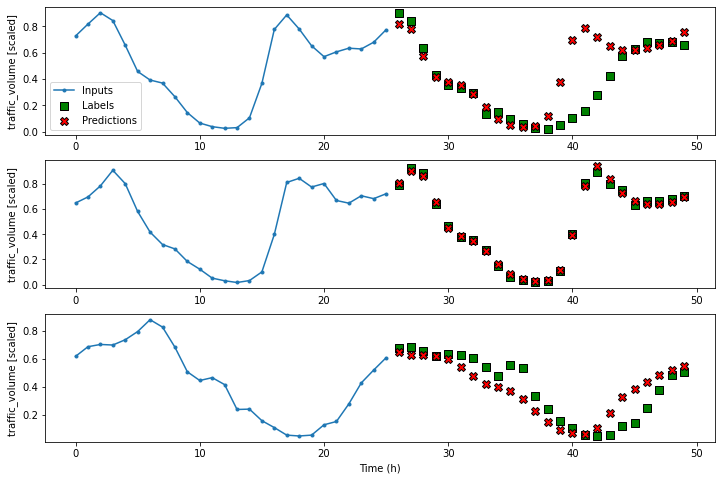

In [29]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)



loaded_combined_dict["multi-output"]["val_perf"]['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
loaded_combined_dict["multi-output"]["perf"]['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)
multi_window.plot(AR_LSTM)
